In [1]:
import pandas as pd
import json

dic = {}
with open('D:/Work/Project/School_Homework/Graduate_Project/predict_Model/reviewLabel/dict.json') as json_file:
    dic = json.load(json_file)

reverseDic=dict([(value,key) for (key,value) in dic.items()])

def decode(encText):
  dectext = ""
  for id in encText:
    if id in reverseDic:
      dectext += reverseDic[id]
    else:
      dectext += "#"
  return dectext


In [2]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),layers.Dense(embed_dim),] )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim, })
        return config

In [3]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,})
        return config

In [4]:
from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense,Input, Dropout, Embedding, Flatten,MaxPooling1D,Conv1D,SimpleRNN,LSTM,GRU,Multiply,GlobalMaxPooling1D
from keras.layers import Bidirectional,Activation,BatchNormalization,GlobalAveragePooling1D,MultiHeadAttention
from keras.callbacks import EarlyStopping
from keras.layers import concatenate
import numpy as np
np.random.seed(0)  # 指定随机数种子
#单词索引的最大个数6000，单句话最大长度60
top_words=len(dic)
max_words=1000    #序列长度
embed_dim=32    #嵌入维度
num_labels=4   #10分类

In [5]:
def build_model(top_words=top_words,max_words=max_words,num_labels=num_labels,mode='LSTM',hidden_dim=[64]):
    if mode=='RNN':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True))
        model.add(Dropout(0.25))
        model.add(SimpleRNN(hidden_dim[0]))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='MLP':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(hidden_dim[0], activation="relu"))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='GRU':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim))
        model.add(Dropout(0.25))
        model.add(GRU(hidden_dim[0]))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='CNN':        #一维卷积
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True))
        model.add(Dropout(0.25))
        model.add(Conv1D(filters=32, kernel_size=3, padding="same",activation="relu"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(hidden_dim[0], activation="relu"))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='CNN+LSTM':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim))
        model.add(Dropout(0.25))
        model.add(Conv1D(filters=32, kernel_size=3, padding="same",activation="relu"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(hidden_dim[0]))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='BiLSTM':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dense(hidden_dim[0], activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation='softmax'))
    #下面的网络采用Funcional API实现
    elif mode=='TextCNN':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        ## 词嵌入使用预训练的词向量
        layer = Embedding(top_words, input_length=max_words, output_dim=embed_dim)(inputs)
        ## 词窗大小分别为3,4,5
        cnn1 = Conv1D(32, 3, padding='same', strides = 1, activation='relu')(layer)
        cnn1 = MaxPooling1D(pool_size=2)(cnn1)
        cnn2 = Conv1D(32, 4, padding='same', strides = 1, activation='relu')(layer)
        cnn2 = MaxPooling1D(pool_size=2)(cnn2)
        cnn3 = Conv1D(32, 5, padding='same', strides = 1, activation='relu')(layer)
        cnn3 = MaxPooling1D(pool_size=2)(cnn3)
        # 合并三个模型的输出向量
        cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)
        x = Flatten()(cnn)
        x = Dense(hidden_dim[0], activation='relu')(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=output)

    elif mode=='Attention':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True)(inputs)
        x = MultiHeadAttention(1, key_dim=embed_dim)(x, x,x)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.2)(x)
        x = Dense(32, activation='relu')(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=[inputs], outputs=output)

    elif mode=='MultiHeadAttention':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True)(inputs)
        x = MultiHeadAttention(8, key_dim=embed_dim)(x, x,x)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.2)(x)
        x = Dense(32, activation='relu')(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=[inputs], outputs=output)

    elif mode=='Attention+BiLSTM':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim)(inputs)
        x = MultiHeadAttention(2, key_dim=embed_dim)(x, x,x)
        x = Bidirectional(LSTM(hidden_dim[0]))(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=output)

    elif mode=='BiGRU+Attention':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim)(inputs)
        x = Bidirectional(GRU(32,return_sequences=True))(x)
        x = MultiHeadAttention(2, key_dim=embed_dim)(x,x,x)
        x = Bidirectional(GRU(32))(x)
        x = Dropout(0.2)(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=[inputs], outputs=output)

    elif mode=='Transformer':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True)(inputs)
        x = TransformerEncoder(embed_dim, 32, 4)(x)
        x = GlobalMaxPooling1D()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs, outputs)

    elif mode=='PositionalEmbedding+Transformer':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x= PositionalEmbedding(sequence_length=max_words, input_dim=top_words, output_dim=embed_dim)(inputs)
        x = TransformerEncoder(embed_dim, 32, 4)(x)
        x = GlobalMaxPooling1D()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs, outputs)

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [6]:
#定义损失和精度的图,和混淆矩阵指标等等
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from matplotlib import pyplot as plt
import seaborn as sns

def plot_loss(history):
    # 显示训练和验证损失图表
    plt.subplots(1,2,figsize=(10,3))
    plt.subplot(121)
    loss = history.history["loss"]
    epochs = range(1, len(loss)+1)
    val_loss = history.history["val_loss"]
    plt.plot(epochs, loss, "bo", label="Training Loss")
    plt.plot(epochs, val_loss, "r", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(122)
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    plt.plot(epochs, acc, "b-", label="Training Acc")
    plt.plot(epochs, val_acc, "r--", label="Validation Acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_confusion_matrix(model,X_test,Y_test_original):
    #dic2 = {0:"Not_Relative", 1:"Very_Negative", 2:"Negative", 3:"Nature", 4:"Positive", 5:"Very_Positive"}
    dic2 = {0:"Not_Relative", 1:"Negative", 2:"Nature", 3:"Positive"}
    #预测概率
    prob=model.predict(X_test)
    #预测类别
    pred=np.argmax(prob,axis=1)
    #数据透视表，混淆矩阵
    pred=pd.Series(pred).map(dic2)
    Y_test_original=pd.Series(Y_test_original).map(dic2)
    table = pd.crosstab(Y_test_original, pred, rownames=['Actual'], colnames=['Predicted'])
    #print(table)
    sns.heatmap(table,cmap='Blues',fmt='.20g', annot=True)
    plt.tight_layout()
    plt.show()
    #计算混淆矩阵的各项指标
    print(classification_report(Y_test_original, pred))
    #科恩Kappa指标
    print('科恩Kappa'+str(cohen_kappa_score(Y_test_original, pred)))

In [7]:
#定义训练函数
def train_fuc(max_words=max_words,mode='BiLSTM+Attention',batch_size=32,epochs=10,hidden_dim=[32],show_loss=True,show_confusion_matrix=True):
    #构建模型
    model=build_model(max_words=max_words,mode=mode)
    print(model.summary())
    es = EarlyStopping(patience=5)
    with tf.device('/GPU:0'):
      history=model.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2, verbose=1,callbacks=[es])
    print('——————————-----------------——訓練完成—————-----------------------------———————')
    # 评估模型
    loss, accuracy = model.evaluate(X_test, Y_test)
    print("val DATA ACC: = {:.4f}".format(accuracy))

    if show_loss:
        plot_loss(history)

    if show_confusion_matrix:
        plot_confusion_matrix(model=model,X_test=X_test,Y_test_original=Y_test_original)

    return model

In [8]:
import random
def shuffle(Question, Answer, split_size):
  x_train = []
  x_val = []
  y_train = []
  y_val = []

  trainSize = []
  valSize = []

  trainCount = []
  valCount = []
  dataSize = pd.Series(Answer).value_counts()
  print(dataSize)
  for i in range(len(dataSize)):
    trainSize.append(dataSize[i] * (1 - split_size))
    valSize.append(dataSize[i] - trainSize[i])
    trainCount.append(0)
    valCount.append(0)

  for i in range(len(Question)):
    dice = random.random()
    choose = 0
    if(dice <= split_size):
      choose = 1

    if(choose == 0):
      if(trainCount[Answer[i]] < trainSize[Answer[i]]):
        trainCount[Answer[i]] += 1
        x_train.append(Question[i])
        y_train.append(Answer[i])
      else:
        valCount[Answer[i]] += 1
        x_val.append(Question[i])
        y_val.append(Answer[i])
    elif(choose == 1):
      if(valCount[Answer[i]] < valCount[Answer[i]]):
        valCount[Answer[i]] += 1
        x_val.append(Question[i])
        y_val.append(Answer[i])
      else:
        trainCount[Answer[i]] += 1
        x_train.append(Question[i])
        y_train.append(Answer[i])
  print(pd.Series(y_train).value_counts())
  print(pd.Series(y_val).value_counts())
  return x_train, x_val, y_train, y_val



In [9]:
#model Create函数
def create_model(max_words=max_words,mode='BiLSTM+Attention',batch_size=32,epochs=10,hidden_dim=[32],show_loss=True,show_confusion_matrix=True):
    #构建模型
    model=build_model(max_words=max_words,mode=mode)
    print(model.summary())
    es = EarlyStopping(patience=5)
    return model

In [10]:
top_words=len(dic)
max_words=1000
batch_size=16
epochs=20
show_confusion_matrix=True
show_loss=True
mode='PositionalEmbedding+Transformer'
model = create_model(mode=mode,batch_size=batch_size,epochs=epochs,show_confusion_matrix=show_confusion_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 positional_embedding (Posi  (None, 1000, 32)          132608    
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, 1000, 32)          19040     
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                             

In [11]:
model.load_weights("D:/Work/Project/School_Homework/Graduate_Project/predict_Model/reviewLabel/binFoodQualityV1.h5")

In [123]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 positional_embedding_6 (Po  (None, 1000, 32)          132608    
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_6 (Tra  (None, 1000, 32)          19040     
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_6 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                           

860
4573
701
0    701
1     65
3     59
2     35
Name: count, dtype: int64
0    583
1     54
3     50
2     30
Name: count, dtype: int64
0    118
1     11
3      9
2      5
Name: count, dtype: int64


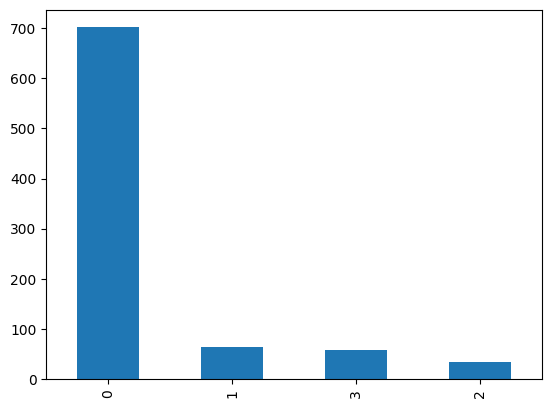

In [21]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import emoji
import re
import math
from pylab import mpl

TARGET = 'food_quality'

maxlen = 1000
vocab_size = len(dic)
# 讀取CSV文件並轉換為DataFrame
df = pd.read_csv('reviewTypeClean.csv')
df.dropna(inplace=True)

texts = df['Comment'].tolist()

full_size_labels = []
full_size_encText = []

labels = []
encText = []

Label0Max = 700
Label0Count = 0


PositiveMax = 700
PositiveCount = 0
for t in range(len(texts)):
  texts[t] = emoji.demojize(texts[t])
  texts[t] = re.sub(':\S+?:', ' ', texts[t])
  encs = []


  if len(texts[t]) > maxlen:
    texts[t] = texts[:maxlen]
  for i in range(maxlen):
    if(i<len(texts[t]) and texts[t][i] in dic):
      encs.append(dic[texts[t][i]])
    else:
      encs.append(0)

  if (encs != None) :
    full_size_encText.append(encs)
    if(df.iloc[t][TARGET] == 1 or df.iloc[t][TARGET] == 2):
      full_size_labels.append(1)
    elif(df.iloc[t][TARGET] == 4 or df.iloc[t][TARGET] == 5):
      full_size_labels.append(3)
    elif(df.iloc[t][TARGET] == 3):
      full_size_labels.append(2)
    else:
      full_size_labels.append(df.iloc[t][TARGET]) 


  if (df.iloc[t][TARGET] == 0):
    if(Label0Count > Label0Max):
      continue
    Label0Count += 1

  if(df.iloc[t][TARGET] == 1 or df.iloc[t][TARGET] == 2):
    labels.append(1)
  elif(df.iloc[t][TARGET] == 4 or df.iloc[t][TARGET] == 5):
    if(PositiveCount > PositiveMax):
      continue

    PositiveCount += 1
    labels.append(3)
  elif(df.iloc[t][TARGET] == 3):
    labels.append(2)
  else:
    labels.append(df.iloc[t][TARGET]) 
  #labels.append(df.iloc[t][TARGET])

  '''if (df.iloc[t][TARGET] == 1):
    labels.append(0)
  elif (df.iloc[t][TARGET] == -1):
    labels.append(1)
  else:
    labels.append(2)'''

  encText.append(encs)



print(len(labels))
print(len(texts))
print(pd.Series(labels).value_counts()[0])
pd.Series(labels).value_counts().plot(kind='bar')
# 將資料集分割成訓練集和測試集
x_train, x_val, y_train, y_val = shuffle(encText, labels, 0.2)
# 將標籤轉換為模型所需的格式
label_dict = {label: i for i, label in enumerate(set(labels))}


y_train = tf.constant([label_dict[label] for label in y_train], dtype=tf.int32)  # 將資料型別轉換為 tf.int32
y_val = tf.constant([label_dict[label] for label in y_val], dtype=tf.int32)  # 將資料型別轉換為 tf.int32
num_classes = len(label_dict)

Y_train = tf.one_hot(y_train, num_classes)

Y_test_original=y_val
Y_test = tf.one_hot(y_val, num_classes)

X_train = tf.constant(x_train)
X_test = tf.constant(x_val)

In [125]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用的GPU索引
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [126]:
with tf.device('/GPU:0'):
    ans = model.predict(full_size_encText)

233/233 [==============================] - 208s 892ms/step


In [127]:
chk = [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]
''',[0,0,0,0,0,0],[0,0,0,0,0,0]]'''
correct = 0
positive = [4,5]
negative = [1,2]
nature = [3]

checkLabel = full_size_labels
alert = []
for i in range(len(checkLabel)):
  chk[checkLabel[i]][np.argmax(ans[i])] += 1
  if checkLabel[i] == np.argmax(ans[i]):
    correct += 1
  if(checkLabel[i] in negative and np.argmax(ans[i]) in positive):
    alert.append(i)

for label in range(len(chk)):
  print(f"lebels {label}'s acc analyze:")
  print(f"predict:{chk[label]}")
  print(f"Total: {sum(chk[label])}")
  print(f"Acc: {chk[label][label] / sum(chk[label])} \n")

print("Total: ")
print(chk)
print(correct / len(checkLabel))

print("Alert")
for i in alert:
  print(decode(encText[i]))
  print(f"Ans:{checkLabel[i]}, Pred:{np.argmax(ans[i])}")
  print(ans[i])
  print()

lebels 0's acc analyze:
predict:[1141, 61, 52, 189, 0, 0]
Total: 1443
Acc: 0.7907137907137907 

lebels 1's acc analyze:
predict:[63, 394, 66, 74, 0, 0]
Total: 597
Acc: 0.6599664991624791 

lebels 2's acc analyze:
predict:[59, 30, 352, 107, 0, 0]
Total: 548
Acc: 0.6423357664233577 

lebels 3's acc analyze:
predict:[670, 210, 468, 3515, 0, 0]
Total: 4863
Acc: 0.7228048529714168 

Total: 
[[1141, 61, 52, 189, 0, 0], [63, 394, 66, 74, 0, 0], [59, 30, 352, 107, 0, 0], [670, 210, 468, 3515, 0, 0]]
0.7250033552543282
Alert


In [18]:
def encode(string):
    string = emoji.demojize(string)
    string = re.sub(':\S+?:', ' ', string)
    encs = []
    if len(string) > maxlen:
        string = string[:maxlen]

    for i in range(maxlen):
        if(i<len(string) and string[i] in dic):
            encs.append(dic[string[i]])
        else:
            encs.append(0)
    if (encs != None) :
        return encs

In [20]:
import emoji
import re
maxlen = 1000
testCase = "吃過多家雞肉飯，覺得這家有合口味，雞肉絲多汁不材，滷汁也調味的很不錯，另外油豆腐個人也覺得入味好吃。\n其他小菜⋯「筍絲」中規中矩、「紅糟肉」偏油偏肥，個人沒有很喜歡。\n另外，用菜環境寬敞、乾淨；也有提供免費停車場。"
encText = []
encs = []
encText.append(encode(testCase))
print(len(encText))
predictions = model.predict(encText)
print(predictions)
print(f"Pred:{np.argmax(predictions[0])}")

1
1/1 [==============================] - 0s 125ms/step
[[0.0011213  0.011261   0.31213298 0.6754848 ]]
Pred:3
